# Tarea 4

Usamos un dataset de analisis de sentimiento multimodal **centrada en entidades** en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

Los tweets vienen de este formato textual, y cada tweet tiene una imagen: 

* `Harriette </s> $T$ moved back to Chicago to care for her mom : And it ' s been terrible # NextDayChi 17` tiene la etiqueta `neutral` y la imagen `twitter2015_images/71274.jpg`
* `Chicago </s> Harriette moved back to $T$ to care for her mom : And it ' s been terrible # NextDayChi 17` tiene la etiqueta `negative` y la imagen `twitter2015_images/71274.jpg`

**Vamos a ver como usar:**
* Fusionar datos de imagenes y de texto para una tarea de clasificacion
* Utilizar las representaciones de las imagenes modalidades tal que (pesos de los encoders congelados)
* Fine-tunear todo el network
* Tratar varios metodos de fusion con capa de attencion
* Utilizar un modelo grande pre-entrenado de manera multimodal como VL-BERT or ViLT
* Utilizar un LMM tipo BLIP3 pre-entrenado con instrucciones, usando Zero-shot

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Good luck!

In [1]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts_Targeted.zip
! unzip Texts_Targeted.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Images.zip
! unzip Images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import MultiheadAttention
from transformers import AutoModel, AutoTokenizer, Blip2Processor, Blip2ForConditionalGeneration
from torchvision import models, transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import numpy as np 
import torch.optim as optim
from torch.optim import AdamW, SGD
import torch.nn.functional as F
from torchvision.models.efficientnet import MBConv
from torchvision.ops.misc import SqueezeExcitation
import time


def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label', 'image_id']]
    X = df.tweet
    y = df.label
    path_image = df.image_id    
    return X, y, path_image

split='train'
X_train, y_train, path_image_train = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev, path_image_dev = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test, path_image_test = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)

label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def unfreeze_params(image_encoder, first_block_to_uf = 7):
    """
    Works at least for EfficientB3. Will unfreeze from layer `first_block_to_uf` (the higher this number the less layers will be unfrozen)
    """
    if first_block_to_uf > 0:
        # Freeze all layers first
        for param in image_encoder.parameters():
            param.requires_grad = False

        # Unfreeze specified block and subsequent layers
        bool_start_unfreezing = False
        for name, layer in list(image_encoder.named_children()):
            if isinstance(layer, nn.Sequential):
                for sub_name, sub_layer in list(layer.named_children()):
                    if int(sub_name) >= first_block_to_uf or name == 'classifier':
                        if name == 'classifier':
                            for param in sub_layer.parameters():
                                param.requires_grad = True
                        else:
                            print(f"Unfreeze layer {sub_name}")
                            if isinstance(sub_layer, nn.Sequential):
                                for sub_sub_layer in sub_layer:
                                    if isinstance(sub_sub_layer, MBConv):
                                        seq_mbconv = list(sub_sub_layer.children())[0]
                                        for sub_seq_mbconv in seq_mbconv:
                                            # is squeeze, change
                                            if not isinstance(sub_seq_mbconv, SqueezeExcitation):
                                                for sub_sub_seq_mbconv in sub_seq_mbconv:
                                                    if not isinstance(sub_sub_seq_mbconv, nn.BatchNorm2d):
                                                        for param in sub_sub_seq_mbconv.parameters():
                                                            param.requires_grad = True
                                            else:
                                                for param in sub_seq_mbconv.parameters():
                                                    param.requires_grad = True

                                    else:
                                        if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                            for param in sub_sub_layer.parameters():
                                                    param.requires_grad = True
                            for sub_sub_layer in sub_layer:
                                if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                    for param in sub_sub_layer.parameters():
                                        param.requires_grad = True

    return image_encoder

c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

**Multimodal Fusion**: The principle is to encode each modality and fuse them together.   

**Text Encoding**: You need to encode the text into a vector. Implement:
* a simple text encoding using a Bag-of-Word and a tf-idf, or an encoding using word2vec and aggregation using the arithmetic mean,
* an encoding using RoBERTa by taking the `<s>` token

**Image Encoding**: You need to encode the image into a vector using an already pre-trained CNN that will create a representation of the image:
* an EfficientNetB2 or EfficientNetB3 pre-trained over ImageNet
* an EfficientNetB2 or EfficientNetB3 already fine-tuned over the Emotion Recognition dataset

#### Text Transformer Model

Use a pre-trained model from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `DataLoader` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `AutoTokenizer` and `AutoModel` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical roberta](https://huggingface.co/roberta-base) `'roberta-base'` 
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example). Be careful if you do this! You will need to change the separation token of the tweets (which is `</s>` here) 
  
#### Multimodal Model 

* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example, you can set the learning rate to `1e-5`, a batch size of `32` and `10` epochs. Be sure that you are converging well, by looking at the train and validation loss curves. These values worked for me! 
 
```python
optimizer_params = {
    'lr': 1e-5,
    'batch_size': 32,
    'num_epochs':10,
}
```

### Naive Fusions

* Concatenate the audio and text representations: before naively fusing them with a MLP layer
* Concatenate the penultimate layers (neural representations): the `<s>` vector for RoBERTa and the representation of the EfficientNet
* Finally, when using the text encoder and the image encoder, run another experiment unfreezing the parameters of the whole network during fine-tuning
* You can try using an EfficientNet already fine-tuned over the Emotion dataset and see the differences, it should help!  

## Utils:

Code functions that can be utils for this task: 
* `MultimodalDataset(torch.utils.data.Dataset)` class that is modular with the different type of encodings from `torch.utils.data.Dataset`
* `training()` function with the training loop
* A class `MultimodalClassifier(nn.Module)` containing the network _per se_. 

Use data augmentation for the vision modality: 
```python
rotation_value = 0.2
# Image transformations for EfficientNet
# For validation/test
self.image_transform = transforms.Compose([
        transforms.CenterCrop(self.image_size),
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Apply data augmentation at training
self.image_transform_data_augmentation = transforms.Compose([
    # transforms.RandomRotation(angle_rotation) # check if this works
    transforms.RandomResizedCrop(self.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=rotation_value * 360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
```

Also do not forget other regularizers like `Torch.nn.dropout` in the multimodal layers! 

In [11]:
def print_plots(train, dev, title="Training and Validation Curve", metric="Loss"):
    """ Function to plot the training and validation curve of a neural network training process """
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f"Training {metric}")
    plt.plot(dev, label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
class MultimodalDataset(Dataset):
    def __init__(self, text_data, image_data, labels, text_encoder, image_size=224, mode='train'):
        self.text_data = text_data
        self.image_data = image_data
        self.labels = labels
        self.text_encoder = text_encoder
        self.image_size = image_size

        rotation_value = 0.2
        if mode == 'train':
            self.image_transform = transforms.Compose([
                transforms.RandomResizedCrop(self.image_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=rotation_value * 360),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:  # validation or test
            self.image_transform = transforms.Compose([
                transforms.CenterCrop(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Text Encoding
        text = self.text_data[idx]
        encoded_text = self.text_encoder(text, return_tensors="pt", truncation=True, padding="max_length", max_length=90)
        input_ids = encoded_text["input_ids"].squeeze()
        attention_mask = encoded_text["attention_mask"].squeeze()

        # Image Encoding
        image = Image.open(self.image_data[idx]).convert("RGB")
        image = self.image_transform(image)

        # Label
        label = torch.tensor(self.labels[idx])

        return input_ids, attention_mask, image, label


In [6]:
class MultimodalClassifier(nn.Module):
    def __init__(self, 
                 use_roberta=True, 
                 freeze_text=True, 
                 freeze_image=True, 
                 text_model_name="roberta-base", 
                 finetune_image=False,
                 fusion_dim=512, 
                 dropout_prob=0.3):
        super(MultimodalClassifier, self).__init__()
        
        self.use_roberta = use_roberta
        self.fusion_dim = fusion_dim

        # Text encoder (RoBERTa)
        if use_roberta:
            self.text_encoder = AutoModel.from_pretrained(text_model_name)
            if freeze_text:
                for param in self.text_encoder.parameters():
                    param.requires_grad = False
            text_embedding_dim = self.text_encoder.config.hidden_size
        else:
            text_embedding_dim = 0  

        # Image encoder (EfficientNet 2)
        if finetune_image: # Load finetuned model based on the code of Tarea 2
            finetuned_model = models.efficientnet_b2(pretrained=True)
            num_ftrs = finetuned_model.classifier[1].in_features
            finetuned_model.classifier[1] = nn.Linear(num_ftrs, 8)
            finetuned_model.load_state_dict(torch.load('finetuning.pt'))
            self.image_encoder = finetuned_model
        else:
            self.image_encoder = models.efficientnet_b2(pretrained=True)
        
        if freeze_image:
            for param in self.image_encoder.parameters():
                param.requires_grad = False
        else:
            unfreeze_params(self.image_encoder)
        
        # Modify image encoder to output a feature vector
        self.image_encoder.classifier = nn.Sequential(
            nn.Linear(self.image_encoder.classifier[1].in_features, fusion_dim),
            nn.ReLU(),
        )

        # Fusion layer
        self.fc_fusion = nn.Linear(text_embedding_dim + fusion_dim, fusion_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(fusion_dim, 3)  # 3 classes: negative, neutral, positive

    def forward(self, input_ids=None, attention_mask=None, image=None):
        # Text encoding
        if self.use_roberta:
            text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        else:
            text_features = torch.zeros((image.size(0), 0), device=image.device)  

        # Image encoding
        image_features = self.image_encoder(image)

        # Concatenate text and image features
        if self.use_roberta:
            fused_features = torch.cat((text_features, image_features), dim=1)
        else:
            fused_features = image_features 

        # Fusion and classification
        fusion_output = self.fc_fusion(fused_features)
        fusion_output = self.dropout(fusion_output)
        output = self.classifier(fusion_output)

        return output

In [4]:
def train_model(model, train_dataset, val_dataset, batch_size=32, num_epochs=10, lr=1e-5, device='cpu'):
    """
    Entrena un modelo multimodal y devuelve el modelo entrenado junto con las pérdidas de entrenamiento y validación.
    
    Args:
        model (nn.Module): El modelo multimodal a entrenar.
        train_dataset (torch.utils.data.Dataset): Conjunto de datos de entrenamiento.
        val_dataset (torch.utils.data.Dataset): Conjunto de datos de validación.
        batch_size (int, optional): Tamaño del batch. Default es 32.
        num_epochs (int, optional): Número de épocas de entrenamiento. Default es 10.
        lr (float, optional): Tasa de aprendizaje. Default es 1e-5.
        device (str, optional): Dispositivo ('cuda' o 'cpu'). Default es 'cuda'.
        
    Returns:
        model (nn.Module): El modelo entrenado.
        train_losses (list): Lista de pérdidas de entrenamiento por época.
        val_losses (list): Lista de pérdidas de validación por época.
        train_accuracies (list): Lista de precisiones de entrenamiento por época.
        val_accuracies (list): Lista de precisiones de validación por época.
        train_f1_scores (list): Lista de puntuaciones F1 de entrenamiento por época.
        val_f1_scores (list): Lista de puntuaciones F1 de validación por época.
    """

    since = time.time()
    
    # Mueve el modelo al dispositivo
    model.to(device)
    
    # Configura el optimizador
    optimizer = AdamW(model.parameters(), lr=lr)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Listas para almacenar pérdidas y métricas
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    
    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        model.train()  # Pone el modelo en modo de entrenamiento
        train_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        
        # Iterar sobre los batches de entrenamiento
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            input_ids, attention_mask, images, labels = batch
            
            # Mueve los datos al dispositivo
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            labels = labels.to(device).long()
            
            # Resetear los gradientes
            optimizer.zero_grad()
            
            # Hacer una pasada hacia adelante
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            
            # Calcular la pérdida (cross-entropy para clasificación entre 3 clases)
            loss = F.cross_entropy(outputs, labels)
            
            # Retropropagar el error
            loss.backward()
            
            # Actualizar los parámetros
            optimizer.step()
            
            # Acumular la pérdida del batch
            train_loss += loss.item()
            
            # Calcular predicciones
            _, preds = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())
        
        # Promediar la pérdida de entrenamiento
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Calcular métricas de entrenamiento
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        
        # Validación después de cada época
        model.eval()  # Pone el modelo en modo de evaluación
        val_loss = 0.0
        all_val_labels = []
        all_val_preds = []
        
        with torch.no_grad():  # No se necesita gradiente durante la validación
            for batch in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{num_epochs}', leave=False):
                input_ids, attention_mask, images, labels = batch
                
                # Mueve los datos al dispositivo
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                images = images.to(device)
                labels = labels.to(device).long()
                
                # Hacer una pasada hacia adelante
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
                
                # Calcular la pérdida
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item()
                
                # Calcular predicciones
                _, preds = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
        
        # Promediar la pérdida de validación
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calcular métricas de validación
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - "
              f"Train Accuracy: {train_accuracy:.4f} - "
              f"Train F1: {train_f1:.4f} - "
              f"Validation Loss: {avg_val_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation F1: {val_f1:.4f} - in {time.time()-since:.0f}s")
        since = time.time()
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores

In [8]:
# TODO: 4 experiments using naive fusion
# Without RoBERTa + frozen-EfficientNet
# frozen-RoBERTa + frozen-EfficientNet
# frozen-RoBERTa + frozen-EfficientNet-emo
# RoBERTa + EfficientNet

In [9]:
model1 = MultimodalClassifier(use_roberta=False, freeze_image=True, finetune_image=False)
model2 = MultimodalClassifier(use_roberta=True, freeze_text=True, freeze_image=True, text_model_name="roberta-base", finetune_image=False)
model3 = MultimodalClassifier(use_roberta=True, freeze_text=True, freeze_image=True, text_model_name="roberta-base", finetune_image=True)
model4 = MultimodalClassifier(use_roberta=True, freeze_text=False, freeze_image=False, text_model_name="roberta-base", finetune_image=False)

c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights

Unfreeze layer 7
Unfreeze layer 8


In [11]:
# Dataset
train_dataset = MultimodalDataset(X_train, path_image_train, label_encoder.transform(y_train), AutoTokenizer.from_pretrained("roberta-base"), mode='train')
val_dataset = MultimodalDataset(X_dev, path_image_dev, label_encoder.transform(y_dev), AutoTokenizer.from_pretrained("roberta-base"), mode='val')

In [ ]:
print("Modelo sin RoBERTa + EfficientNet congelado")
model1, train_losses1, val_losses1, train_accuracies1, val_accuracies1, train_f1_scores1, val_f1_scores1 = train_model(model1, train_dataset, val_dataset, num_epochs=15, device=device)
print("Modelo con RoBERTa congelado + EfficientNet congelado")
model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2, train_f1_scores2, val_f1_scores2 = train_model(model2, train_dataset, val_dataset, num_epochs=15, device=device)
print("Modelo con RoBERTa congelado + EfficientNet fine-tuned con emociones congeladas")
model3, train_losses3, val_losses3, train_accuracies3, val_accuracies3, train_f1_scores3, val_f1_scores3 = train_model(model3, train_dataset, val_dataset, num_epochs=15, device=device)
print("Modelo con RoBERTa + EfficientNet")
model4, train_losses4, val_losses4, train_accuracies4, val_accuracies4, train_f1_scores4, val_f1_scores4 = train_model(model4, train_dataset, val_dataset, num_epochs=5, device=device)

Modelo sin RoBERTa + EfficientNet congelado


Epoch 1/15 - Train Loss: 1.0128 - Train Accuracy: 0.4962 - Train F1: 0.3860 - Validation Loss: 0.9925 - Validation Accuracy: 0.5157 - Validation F1: 0.3515 - in 82s


Epoch 2/15 - Train Loss: 0.9666 - Train Accuracy: 0.5225 - Train F1: 0.3588 - Validation Loss: 0.9818 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 82s


Epoch 3/15 - Train Loss: 0.9621 - Train Accuracy: 0.5229 - Train F1: 0.3631 - Validation Loss: 0.9765 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 82s


Epoch 4/15 - Train Loss: 0.9592 - Train Accuracy: 0.5225 - Train F1: 0.3601 - Validation Loss: 0.9736 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 79s


Epoch 5/15 - Train Loss: 0.9533 - Train Accuracy: 0.5205 - Train F1: 0.3604 - Validation Loss: 0.9707 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 79s


Epoch 6/15 - Train Loss: 0.9504 - Train Accuracy: 0.5229 - Train F1: 0.3670 - Validation Loss: 0.9689 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 78s


Epoch 7/15 - Train Loss: 0.9499 - Train Accuracy: 0.5251 - Train F1: 0.3766 - Validation Loss: 0.9674 - Validation Accuracy: 0.5183 - Validation F1: 0.3557 - in 79s


Epoch 8/15 - Train Loss: 0.9465 - Train Accuracy: 0.5234 - Train F1: 0.3762 - Validation Loss: 0.9662 - Validation Accuracy: 0.5200 - Validation F1: 0.3596 - in 78s


Epoch 9/15 - Train Loss: 0.9479 - Train Accuracy: 0.5208 - Train F1: 0.3848 - Validation Loss: 0.9645 - Validation Accuracy: 0.5178 - Validation F1: 0.3586 - in 79s


Epoch 10/15 - Train Loss: 0.9463 - Train Accuracy: 0.5237 - Train F1: 0.3915 - Validation Loss: 0.9637 - Validation Accuracy: 0.5170 - Validation F1: 0.3528 - in 79s


Epoch 11/15 - Train Loss: 0.9412 - Train Accuracy: 0.5286 - Train F1: 0.4033 - Validation Loss: 0.9626 - Validation Accuracy: 0.5170 - Validation F1: 0.3590 - in 79s


Epoch 12/15 - Train Loss: 0.9418 - Train Accuracy: 0.5259 - Train F1: 0.4048 - Validation Loss: 0.9623 - Validation Accuracy: 0.5183 - Validation F1: 0.3580 - in 79s


Epoch 13/15 - Train Loss: 0.9411 - Train Accuracy: 0.5284 - Train F1: 0.4073 - Validation Loss: 0.9612 - Validation Accuracy: 0.5187 - Validation F1: 0.3679 - in 79s


Epoch 14/15 - Train Loss: 0.9396 - Train Accuracy: 0.5342 - Train F1: 0.4326 - Validation Loss: 0.9611 - Validation Accuracy: 0.5178 - Validation F1: 0.3638 - in 79s


Epoch 15/15 - Train Loss: 0.9399 - Train Accuracy: 0.5320 - Train F1: 0.4253 - Validation Loss: 0.9607 - Validation Accuracy: 0.5191 - Validation F1: 0.3643 - in 78s
Modelo con RoBERTa congelado + EfficientNet congelado


Epoch 1/15:   0%|          | 0/211 [00:00<?, ?it/s]c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/15 - Train Loss: 0.9963 - Train Accuracy: 0.5094 - Train F1: 0.3749 - Validation Loss: 0.9748 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 98s


Epoch 2/15 - Train Loss: 0.9593 - Train Accuracy: 0.5194 - Train F1: 0.3613 - Validation Loss: 0.9700 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 98s


Epoch 3/15 - Train Loss: 0.9567 - Train Accuracy: 0.5240 - Train F1: 0.3711 - Validation Loss: 0.9665 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 98s


Epoch 4/15 - Train Loss: 0.9514 - Train Accuracy: 0.5247 - Train F1: 0.3741 - Validation Loss: 0.9636 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 98s


Epoch 5/15 - Train Loss: 0.9515 - Train Accuracy: 0.5226 - Train F1: 0.3768 - Validation Loss: 0.9609 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 99s


Epoch 6/15 - Train Loss: 0.9448 - Train Accuracy: 0.5251 - Train F1: 0.3809 - Validation Loss: 0.9583 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 101s


Epoch 7/15 - Train Loss: 0.9405 - Train Accuracy: 0.5272 - Train F1: 0.3877 - Validation Loss: 0.9571 - Validation Accuracy: 0.5191 - Validation F1: 0.3592 - in 100s


Epoch 8/15 - Train Loss: 0.9377 - Train Accuracy: 0.5314 - Train F1: 0.4057 - Validation Loss: 0.9548 - Validation Accuracy: 0.5200 - Validation F1: 0.3626 - in 99s


Epoch 9/15 - Train Loss: 0.9372 - Train Accuracy: 0.5302 - Train F1: 0.4143 - Validation Loss: 0.9525 - Validation Accuracy: 0.5187 - Validation F1: 0.3567 - in 99s


Epoch 10/15 - Train Loss: 0.9316 - Train Accuracy: 0.5369 - Train F1: 0.4224 - Validation Loss: 0.9514 - Validation Accuracy: 0.5261 - Validation F1: 0.3866 - in 99s


Epoch 11/15 - Train Loss: 0.9338 - Train Accuracy: 0.5275 - Train F1: 0.4185 - Validation Loss: 0.9491 - Validation Accuracy: 0.5218 - Validation F1: 0.3694 - in 99s


Epoch 12/15 - Train Loss: 0.9310 - Train Accuracy: 0.5342 - Train F1: 0.4342 - Validation Loss: 0.9480 - Validation Accuracy: 0.5205 - Validation F1: 0.3680 - in 99s


Epoch 13/15 - Train Loss: 0.9283 - Train Accuracy: 0.5412 - Train F1: 0.4404 - Validation Loss: 0.9462 - Validation Accuracy: 0.5261 - Validation F1: 0.3871 - in 100s


Epoch 14/15 - Train Loss: 0.9215 - Train Accuracy: 0.5474 - Train F1: 0.4545 - Validation Loss: 0.9450 - Validation Accuracy: 0.5261 - Validation F1: 0.3826 - in 103s


Epoch 15/15 - Train Loss: 0.9212 - Train Accuracy: 0.5459 - Train F1: 0.4539 - Validation Loss: 0.9434 - Validation Accuracy: 0.5244 - Validation F1: 0.3810 - in 103s
Modelo con RoBERTa congelado + EfficientNet fine-tuned con emociones congeladas


Epoch 1/15 - Train Loss: 0.9936 - Train Accuracy: 0.4928 - Train F1: 0.4217 - Validation Loss: 0.9706 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 103s


Epoch 2/15 - Train Loss: 0.9556 - Train Accuracy: 0.5204 - Train F1: 0.3671 - Validation Loss: 0.9669 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 103s


Epoch 3/15 - Train Loss: 0.9537 - Train Accuracy: 0.5216 - Train F1: 0.3711 - Validation Loss: 0.9618 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 103s


Epoch 4/15 - Train Loss: 0.9487 - Train Accuracy: 0.5228 - Train F1: 0.3739 - Validation Loss: 0.9589 - Validation Accuracy: 0.5165 - Validation F1: 0.3519 - in 102s


Epoch 5/15 - Train Loss: 0.9458 - Train Accuracy: 0.5216 - Train F1: 0.3856 - Validation Loss: 0.9562 - Validation Accuracy: 0.5178 - Validation F1: 0.3564 - in 102s


Epoch 6/15 - Train Loss: 0.9398 - Train Accuracy: 0.5314 - Train F1: 0.3996 - Validation Loss: 0.9542 - Validation Accuracy: 0.5183 - Validation F1: 0.3573 - in 99s


Epoch 7/15 - Train Loss: 0.9378 - Train Accuracy: 0.5312 - Train F1: 0.4117 - Validation Loss: 0.9518 - Validation Accuracy: 0.5191 - Validation F1: 0.3667 - in 99s


Epoch 8/15 - Train Loss: 0.9365 - Train Accuracy: 0.5378 - Train F1: 0.4322 - Validation Loss: 0.9505 - Validation Accuracy: 0.5222 - Validation F1: 0.3724 - in 99s


Epoch 9/15 - Train Loss: 0.9339 - Train Accuracy: 0.5406 - Train F1: 0.4462 - Validation Loss: 0.9493 - Validation Accuracy: 0.5209 - Validation F1: 0.3697 - in 100s


Epoch 10/15 - Train Loss: 0.9302 - Train Accuracy: 0.5321 - Train F1: 0.4317 - Validation Loss: 0.9472 - Validation Accuracy: 0.5283 - Validation F1: 0.4082 - in 99s


Epoch 11/15 - Train Loss: 0.9287 - Train Accuracy: 0.5426 - Train F1: 0.4430 - Validation Loss: 0.9460 - Validation Accuracy: 0.5322 - Validation F1: 0.4310 - in 99s


Epoch 12/15 - Train Loss: 0.9271 - Train Accuracy: 0.5425 - Train F1: 0.4618 - Validation Loss: 0.9439 - Validation Accuracy: 0.5296 - Validation F1: 0.4203 - in 98s


Epoch 13/15 - Train Loss: 0.9209 - Train Accuracy: 0.5443 - Train F1: 0.4602 - Validation Loss: 0.9426 - Validation Accuracy: 0.5274 - Validation F1: 0.4114 - in 99s


Epoch 14/15 - Train Loss: 0.9182 - Train Accuracy: 0.5505 - Train F1: 0.4712 - Validation Loss: 0.9419 - Validation Accuracy: 0.5261 - Validation F1: 0.4101 - in 99s


Epoch 15/15 - Train Loss: 0.9203 - Train Accuracy: 0.5418 - Train F1: 0.4591 - Validation Loss: 0.9403 - Validation Accuracy: 0.5335 - Validation F1: 0.4206 - in 99s
Modelo con RoBERTa + EfficientNet


Epoch 1/5 - Train Loss: 0.8270 - Train Accuracy: 0.5998 - Train F1: 0.5729 - Validation Loss: 0.6971 - Validation Accuracy: 0.6719 - Validation F1: 0.6714 - in 153s


Epoch 2/5 - Train Loss: 0.6133 - Train Accuracy: 0.7284 - Train F1: 0.7280 - Validation Loss: 0.6765 - Validation Accuracy: 0.7010 - Validation F1: 0.7008 - in 152s


Epoch 3/5 - Train Loss: 0.5120 - Train Accuracy: 0.7828 - Train F1: 0.7828 - Validation Loss: 0.7166 - Validation Accuracy: 0.7006 - Validation F1: 0.7005 - in 152s


Epoch 4/5 - Train Loss: 0.4178 - Train Accuracy: 0.8290 - Train F1: 0.8292 - Validation Loss: 0.7163 - Validation Accuracy: 0.7211 - Validation F1: 0.7141 - in 152s


Epoch 5/5 - Train Loss: 0.3436 - Train Accuracy: 0.8646 - Train F1: 0.8646 - Validation Loss: 0.7660 - Validation Accuracy: 0.7311 - Validation F1: 0.7291 - in 152s


Modelo sin RoBERTa y EfficientNetB2 congelado


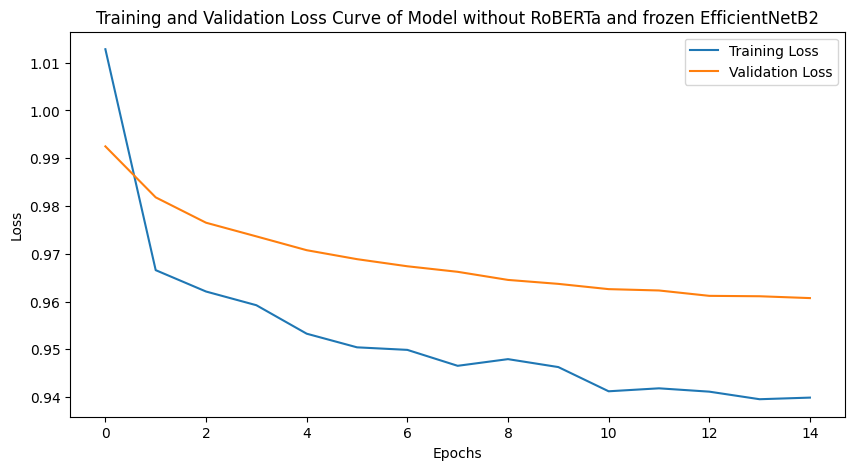

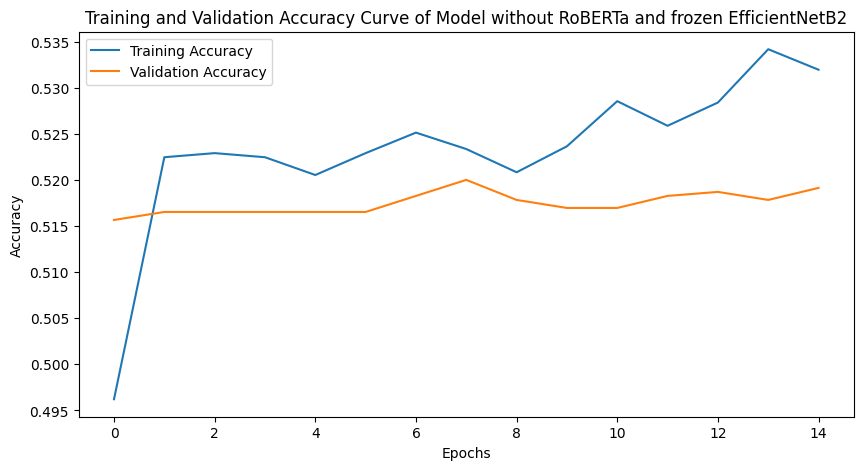

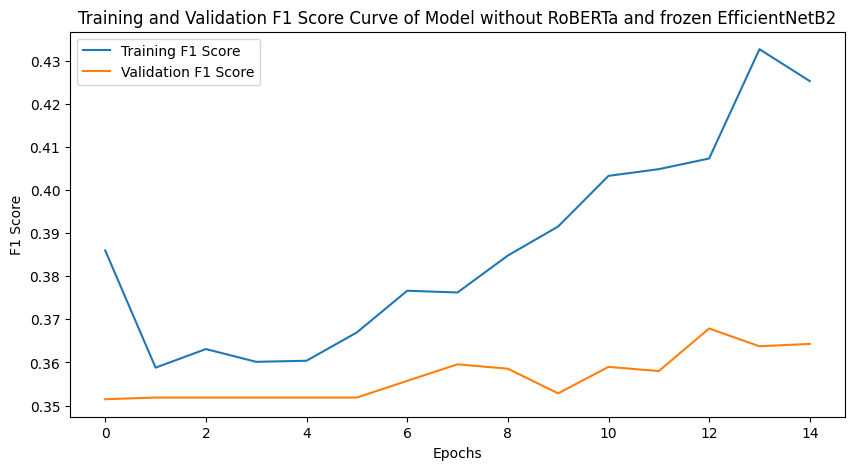

Modelo con RoBERTa congelado y EfficientNetB2 congelado


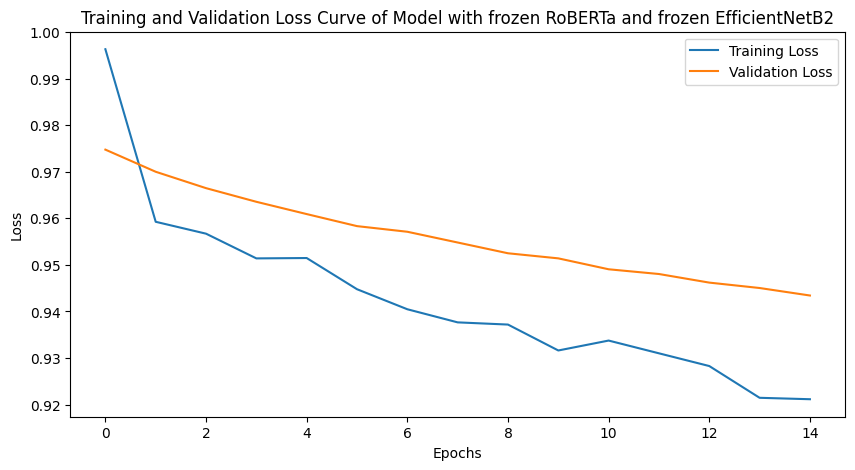

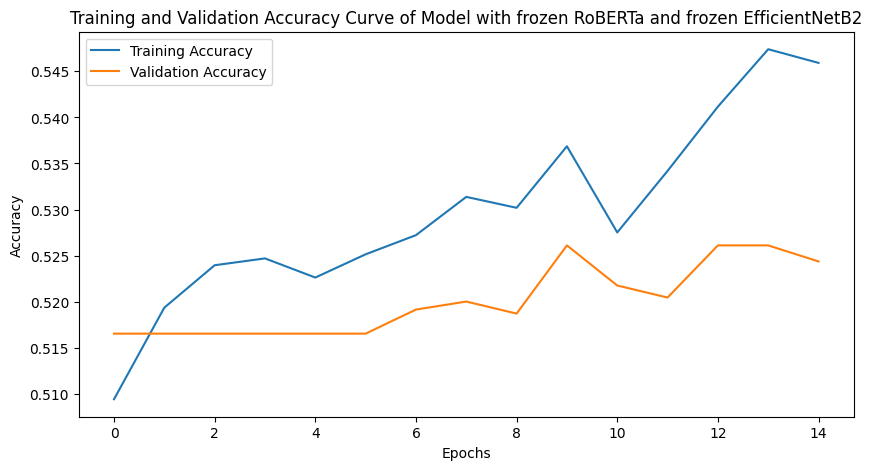

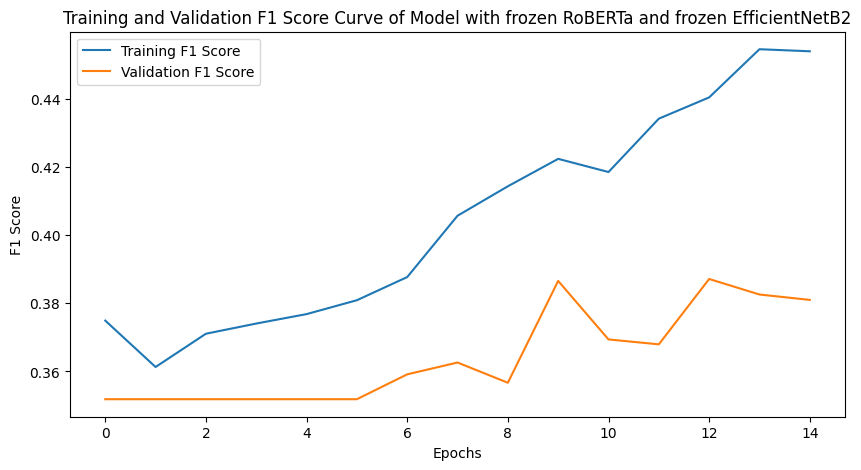

Modelo con RoBERTa congelado y EfficientNetB2 preentrenado en datos de emociones


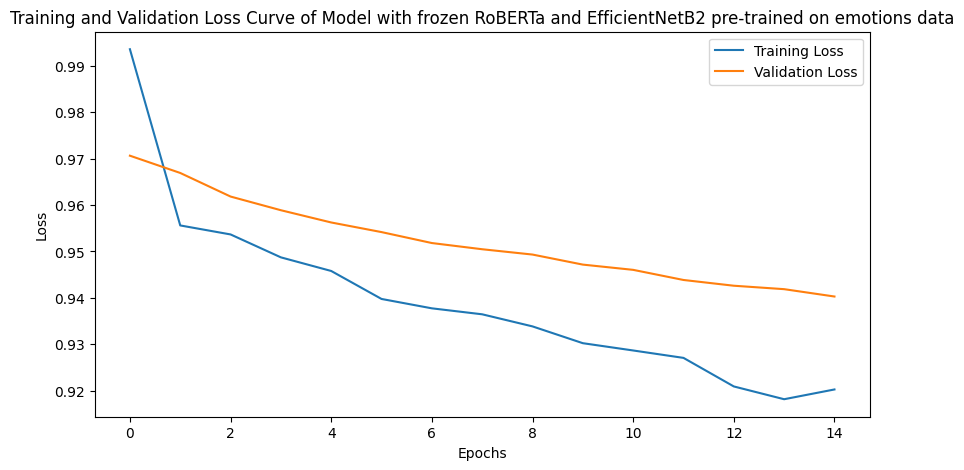

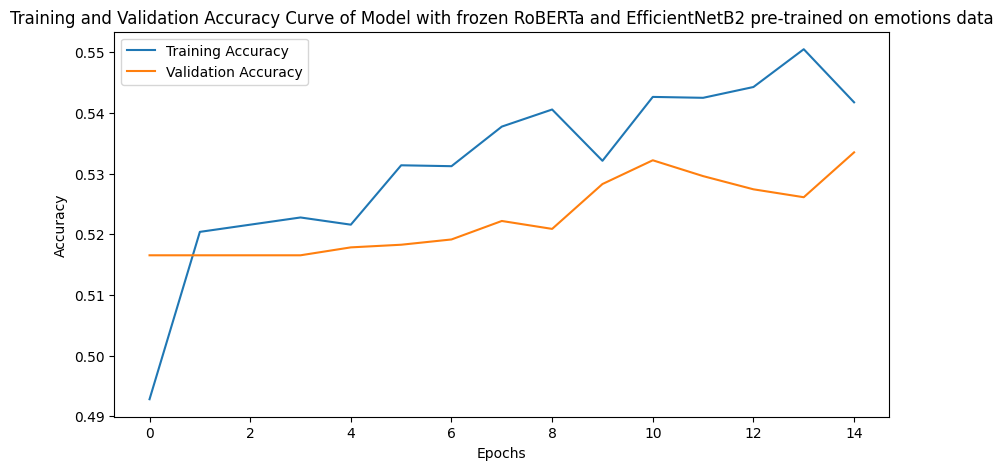

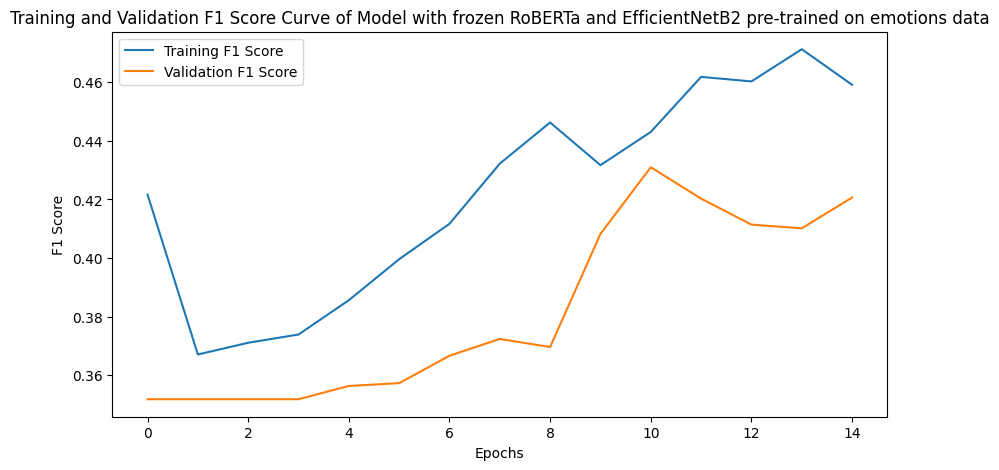

Modelo con RoBERTa y EfficientNetB2 sin congelar


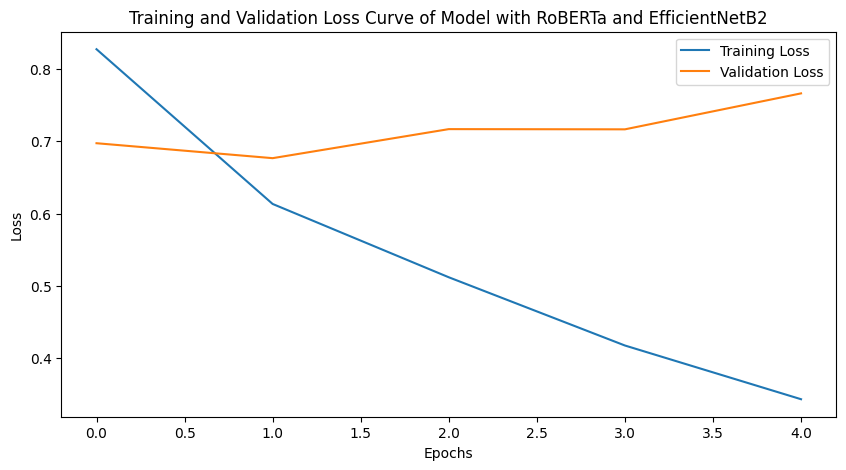

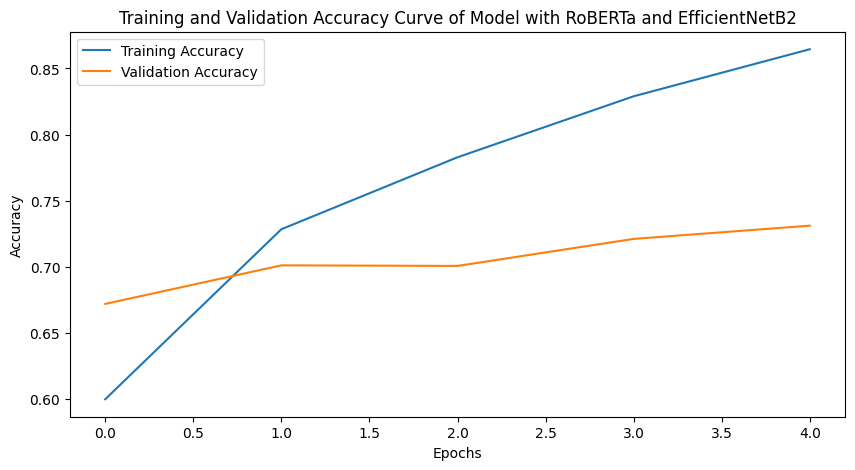

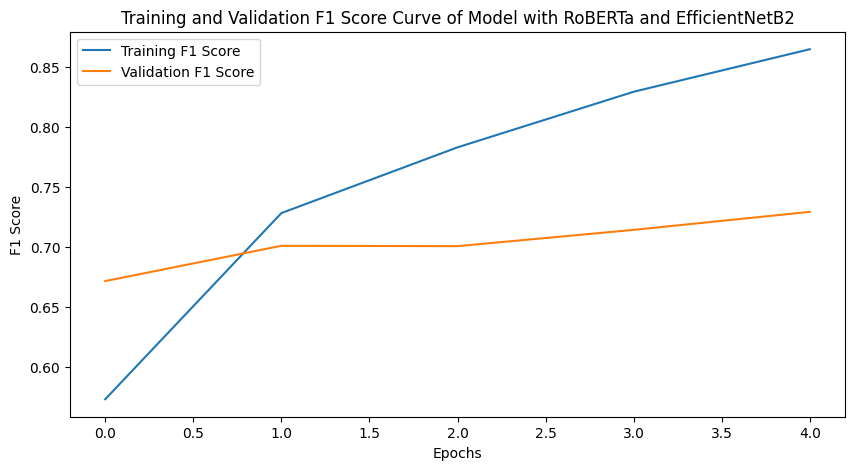

In [11]:
print("Modelo sin RoBERTa y EfficientNetB2 congelado")
print_plots(train_losses1, val_losses1 , title="Training and Validation Loss Curve of Model without RoBERTa and frozen EfficientNetB2", metric="Loss")
print_plots(train_accuracies1, val_accuracies1, title="Training and Validation Accuracy Curve of Model without RoBERTa and frozen EfficientNetB2", metric="Accuracy")
print_plots(train_f1_scores1, val_f1_scores1, title="Training and Validation F1 Score Curve of Model without RoBERTa and frozen EfficientNetB2", metric="F1 Score")
print("Modelo con RoBERTa congelado y EfficientNetB2 congelado")
print_plots(train_losses2, val_losses2, title="Training and Validation Loss Curve of Model with frozen RoBERTa and frozen EfficientNetB2")
print_plots(train_accuracies2, val_accuracies2, title="Training and Validation Accuracy Curve of Model with frozen RoBERTa and frozen EfficientNetB2", metric="Accuracy")
print_plots(train_f1_scores2, val_f1_scores2, title="Training and Validation F1 Score Curve of Model with frozen RoBERTa and frozen EfficientNetB2", metric="F1 Score")
print("Modelo con RoBERTa congelado y EfficientNetB2 preentrenado en datos de emociones")
print_plots(train_losses3, val_losses3, title="Training and Validation Loss Curve of Model with frozen RoBERTa and EfficientNetB2 pre-trained on emotions data")
print_plots(train_accuracies3, val_accuracies3, title="Training and Validation Accuracy Curve of Model with frozen RoBERTa and EfficientNetB2 pre-trained on emotions data", metric="Accuracy")
print_plots(train_f1_scores3, val_f1_scores3, title="Training and Validation F1 Score Curve of Model with frozen RoBERTa and EfficientNetB2 pre-trained on emotions data", metric="F1 Score")
print("Modelo con RoBERTa y EfficientNetB2 sin congelar")
print_plots(train_losses4, val_losses4, title="Training and Validation Loss Curve of Model with RoBERTa and EfficientNetB2")
print_plots(train_accuracies4, val_accuracies4, title="Training and Validation Accuracy Curve of Model with RoBERTa and EfficientNetB2", metric="Accuracy")
print_plots(train_f1_scores4, val_f1_scores4, title="Training and Validation F1 Score Curve of Model with RoBERTa and EfficientNetB2", metric="F1 Score")

### Attention Fusions

Implement attention mechanism on the different modalities in order to know its importance for the final decision while fusing.

* Self-attention
* Cross-modal Attention

Use the `MultiheadAttention` function from pytorch, with 2 heads, or a concatenation of the vector weighted with attention and the initial vector.  

Here is an example for the cross-modal attention, in the forward: 
```python
att_text_embedding, _ = self.text_to_image_attention(text_embedding, image_embedding, image_embedding)
text_embedding = torch.cat((text_embedding, att_text_embedding), dim=1)
text_embedding = torch.relu(self.text_self_attention_fc(text_embedding))

att_image_embedding, _ = self.image_to_text_attention(image_embedding, text_embedding, text_embedding)
image_embedding = torch.cat((image_embedding, att_image_embedding), dim=1)
image_embedding = torch.relu(self.text_self_attention_fc(image_embedding))
```                    

For these experiments, you should unfreeze a part of the whole network, using the `unfreeze_params()` function. 

In [5]:
def unfreeze_params(image_encoder, first_block_to_uf = 7):
    """
    Works at least for EfficientB3. Will unfreeze from layer `first_block_to_uf` (the higher this number the less layers will be unfrozen)
    """
    if first_block_to_uf > 0:
        # Freeze all layers first
        for param in image_encoder.parameters():
            param.requires_grad = False

        # Unfreeze specified block and subsequent layers
        bool_start_unfreezing = False
        for name, layer in list(image_encoder.named_children()):
            if isinstance(layer, nn.Sequential):
                for sub_name, sub_layer in list(layer.named_children()):
                    if int(sub_name) >= first_block_to_uf or name == 'classifier':
                        if name == 'classifier':
                            for param in sub_layer.parameters():
                                param.requires_grad = True
                        else:
                            print(f"Unfreeze layer {sub_name}")
                            if isinstance(sub_layer, nn.Sequential):
                                for sub_sub_layer in sub_layer:
                                    if isinstance(sub_sub_layer, MBConv):
                                        seq_mbconv = list(sub_sub_layer.children())[0]
                                        for sub_seq_mbconv in seq_mbconv:
                                            # is squeeze, change
                                            if not isinstance(sub_seq_mbconv, SqueezeExcitation):
                                                for sub_sub_seq_mbconv in sub_seq_mbconv:
                                                    if not isinstance(sub_sub_seq_mbconv, nn.BatchNorm2d):
                                                        for param in sub_sub_seq_mbconv.parameters():
                                                            param.requires_grad = True
                                            else:
                                                for param in sub_seq_mbconv.parameters():
                                                    param.requires_grad = True

                                    else:
                                        if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                            for param in sub_sub_layer.parameters():
                                                    param.requires_grad = True
                            for sub_sub_layer in sub_layer:
                                if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                    for param in sub_sub_layer.parameters():
                                        param.requires_grad = True

    return image_encoder

In [13]:
# TODO 2 experiments

In [15]:
class AttentionFusionModel(nn.Module):
    def __init__(self, attention="self"):
        super(AttentionFusionModel, self).__init__()

        # Text encoder (RoBERTa)
        self.text_encoder = AutoModel.from_pretrained("roberta-base")
        text_embedding_dim = self.text_encoder.config.hidden_size
        self.text_projection = nn.Linear(text_embedding_dim, 512)

        # Image encoder (EfficientNet B2)
        efficientnet = models.efficientnet_b2(pretrained=True)
        self.image_encoder = efficientnet
        self.image_encoder.classifier = nn.Sequential(
            nn.Linear(self.image_encoder.classifier[1].in_features, 512),
            nn.ReLU(),
        )
        unfreeze_params(self.image_encoder, first_block_to_uf=7)

        # Capas de atención
        self.text_to_image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=4)
        self.image_to_text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=4)

        # Fusion layer
        self.fc_fusion = nn.Linear(512 + 512, 512)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(512, 3)

        for layer in [self.text_projection, self.fc_fusion, self.classifier]:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        # Almacenamos el parámetro para saber qué tipo de atención usar
        self.attention_type = attention

    def forward(self, input_ids, attention_mask, image):
        # Procesar el texto
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = text_output.last_hidden_state 
        text_embedding = self.text_projection(text_embedding)  

        # Procesar la imagen
        image_embedding = self.image_encoder(image)  
        image_embedding = image_embedding.unsqueeze(1) 

        if self.attention_type == "self":
            att_text, _ = self.text_to_image_attention(
                query=text_embedding.permute(1, 0, 2),  
                key=text_embedding.permute(1, 0, 2),   
                value=text_embedding.permute(1, 0, 2)
            )
            att_text = att_text.permute(1, 0, 2)  

            att_image, _ = self.text_to_image_attention(
                query=image_embedding.permute(1, 0, 2), 
                key=image_embedding.permute(1, 0, 2),   
                value=image_embedding.permute(1, 0, 2)
            )
            att_image = att_image.permute(1, 0, 2)  

            fusion = torch.cat((att_text[:, 0, :], att_image.squeeze(1)), dim=1)  

        elif self.attention_type == "cross":
            att_text_to_image, _ = self.text_to_image_attention(
                query=text_embedding.permute(1, 0, 2),  
                key=image_embedding.permute(1, 0, 2),  
                value=image_embedding.permute(1, 0, 2)
            )
            att_text_to_image = att_text_to_image.permute(1, 0, 2) 

            # Concatenar y fusionar
            fusion = torch.cat((att_text_to_image[:, 0, :], image_embedding.squeeze(1)), dim=1) 

        # Fusion layer
        fusion = self.fc_fusion(fusion)
        fusion = self.dropout(fusion)
        output = self.classifier(fusion)
        return output


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfreeze layer 7
Unfreeze layer 8


Epoch 1/5 - Train Loss: 0.7887 - Train Accuracy: 0.6248 - Train F1: 0.6108 - Validation Loss: 0.6675 - Validation Accuracy: 0.6902 - Validation F1: 0.6903 - in 252s


Epoch 2/5 - Train Loss: 0.5880 - Train Accuracy: 0.7388 - Train F1: 0.7381 - Validation Loss: 0.6736 - Validation Accuracy: 0.6971 - Validation F1: 0.6896 - in 252s


Epoch 3/5 - Train Loss: 0.4730 - Train Accuracy: 0.8020 - Train F1: 0.8015 - Validation Loss: 0.6629 - Validation Accuracy: 0.7324 - Validation F1: 0.7323 - in 250s


Epoch 4/5 - Train Loss: 0.3816 - Train Accuracy: 0.8460 - Train F1: 0.8460 - Validation Loss: 0.7723 - Validation Accuracy: 0.7158 - Validation F1: 0.7176 - in 216s


Epoch 5/5 - Train Loss: 0.2867 - Train Accuracy: 0.8844 - Train F1: 0.8844 - Validation Loss: 0.8326 - Validation Accuracy: 0.7163 - Validation F1: 0.7167 - in 222s
Modelo con atención propia


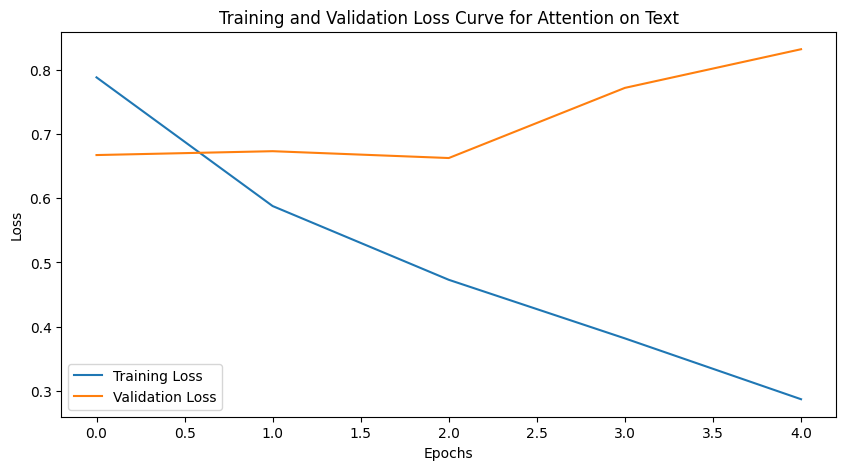

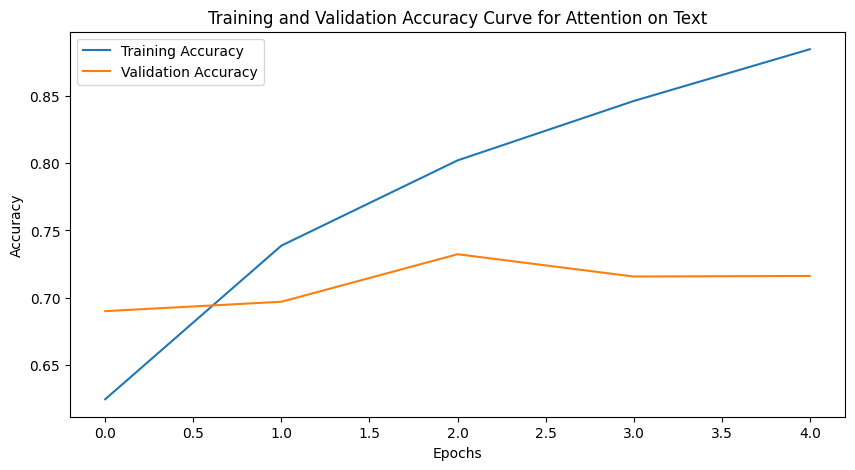

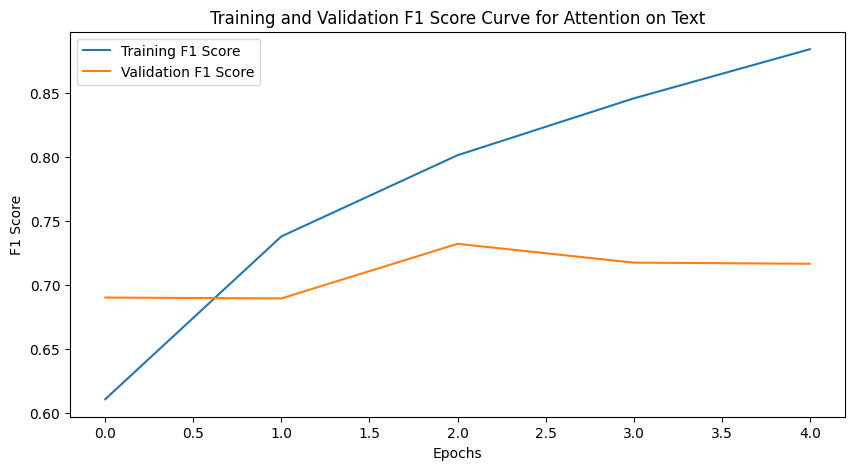

In [17]:
model5 = AttentionFusionModel(attention="self")

model5, train_losses5, val_losses5, train_accuracies5, val_accuracies5, train_f1_scores5, val_f1_scores5 = train_model(model5, train_dataset, val_dataset, num_epochs=5, device=device)

print("Modelo con atención propia")
print_plots(train_losses5, val_losses5, title="Training and Validation Loss Curve for Attention on Text")
print_plots(train_accuracies5, val_accuracies5, title="Training and Validation Accuracy Curve for Attention on Text", metric="Accuracy")
print_plots(train_f1_scores5, val_f1_scores5, title="Training and Validation F1 Score Curve for Attention on Text", metric="F1 Score")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfreeze layer 7
Unfreeze layer 8


Epoch 1/15 - Train Loss: 0.9824 - Train Accuracy: 0.5010 - Train F1: 0.4047 - Validation Loss: 0.9758 - Validation Accuracy: 0.5135 - Validation F1: 0.3713 - in 170s


Epoch 2/15 - Train Loss: 0.9615 - Train Accuracy: 0.5113 - Train F1: 0.4107 - Validation Loss: 0.9704 - Validation Accuracy: 0.5165 - Validation F1: 0.3627 - in 174s


Epoch 3/15 - Train Loss: 0.9527 - Train Accuracy: 0.5250 - Train F1: 0.4257 - Validation Loss: 0.9670 - Validation Accuracy: 0.5174 - Validation F1: 0.3938 - in 219s


Epoch 4/15 - Train Loss: 0.9475 - Train Accuracy: 0.5198 - Train F1: 0.4285 - Validation Loss: 0.9661 - Validation Accuracy: 0.5178 - Validation F1: 0.3782 - in 247s


Epoch 5/15 - Train Loss: 0.9478 - Train Accuracy: 0.5259 - Train F1: 0.4394 - Validation Loss: 0.9653 - Validation Accuracy: 0.5157 - Validation F1: 0.4040 - in 244s


Epoch 6/15 - Train Loss: 0.9420 - Train Accuracy: 0.5257 - Train F1: 0.4390 - Validation Loss: 0.9645 - Validation Accuracy: 0.5139 - Validation F1: 0.4082 - in 235s


Epoch 7/15 - Train Loss: 0.9390 - Train Accuracy: 0.5274 - Train F1: 0.4519 - Validation Loss: 0.9637 - Validation Accuracy: 0.5131 - Validation F1: 0.3862 - in 234s


Epoch 8/15 - Train Loss: 0.9388 - Train Accuracy: 0.5275 - Train F1: 0.4468 - Validation Loss: 0.9633 - Validation Accuracy: 0.5131 - Validation F1: 0.4225 - in 239s


Epoch 9/15 - Train Loss: 0.9355 - Train Accuracy: 0.5305 - Train F1: 0.4553 - Validation Loss: 0.9649 - Validation Accuracy: 0.5113 - Validation F1: 0.4096 - in 252s


Epoch 10/15 - Train Loss: 0.9381 - Train Accuracy: 0.5312 - Train F1: 0.4561 - Validation Loss: 0.9632 - Validation Accuracy: 0.5117 - Validation F1: 0.4044 - in 253s


Epoch 11/15 - Train Loss: 0.9336 - Train Accuracy: 0.5289 - Train F1: 0.4539 - Validation Loss: 0.9622 - Validation Accuracy: 0.5157 - Validation F1: 0.4287 - in 235s


Epoch 12/15 - Train Loss: 0.9281 - Train Accuracy: 0.5336 - Train F1: 0.4573 - Validation Loss: 0.9631 - Validation Accuracy: 0.5183 - Validation F1: 0.4247 - in 234s


Epoch 13/15 - Train Loss: 0.9258 - Train Accuracy: 0.5418 - Train F1: 0.4731 - Validation Loss: 0.9635 - Validation Accuracy: 0.5200 - Validation F1: 0.4283 - in 241s


Epoch 14/15 - Train Loss: 0.9237 - Train Accuracy: 0.5419 - Train F1: 0.4753 - Validation Loss: 0.9667 - Validation Accuracy: 0.5161 - Validation F1: 0.4167 - in 239s


Epoch 15/15 - Train Loss: 0.9235 - Train Accuracy: 0.5400 - Train F1: 0.4732 - Validation Loss: 0.9662 - Validation Accuracy: 0.5196 - Validation F1: 0.4272 - in 237s
Modelo con atención cruzada


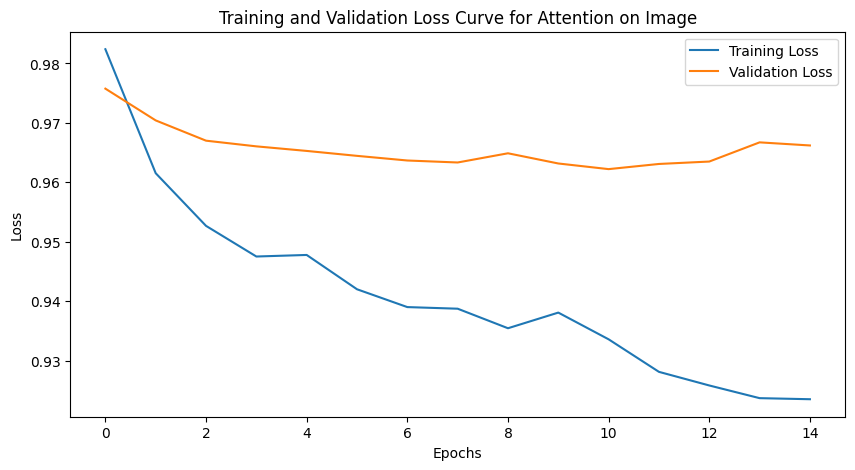

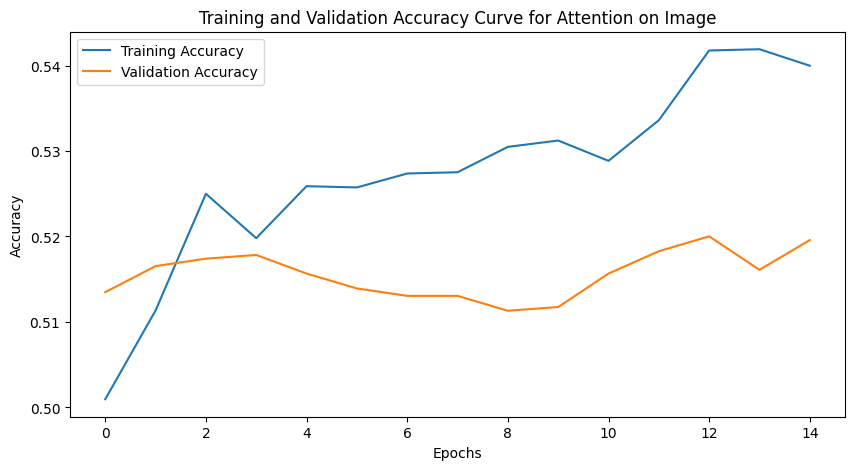

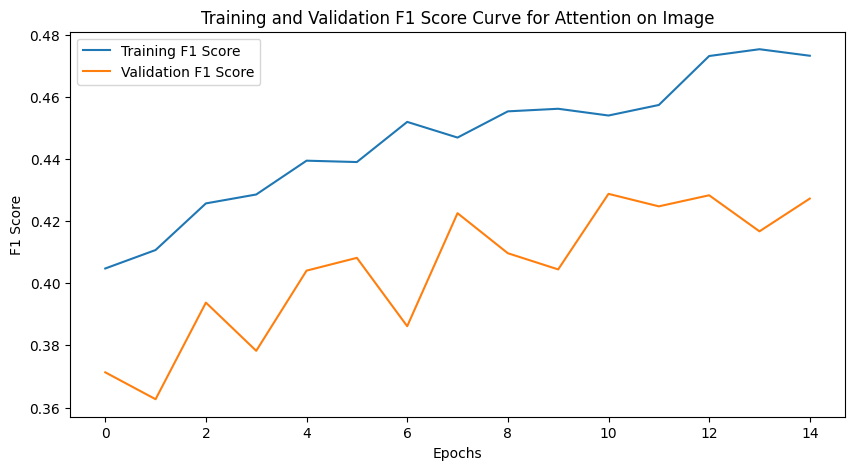

In [16]:
model6 = AttentionFusionModel(attention="cross")
model6, train_losses6, val_losses6, train_accuracies6, val_accuracies6, train_f1_scores6, val_f1_scores6 = train_model(model6, train_dataset, val_dataset, num_epochs=15, device=device)

print("Modelo con atención cruzada")
print_plots(train_losses6, val_losses6, title="Training and Validation Loss Curve for Attention on Image")
print_plots(train_accuracies6, val_accuracies6, title="Training and Validation Accuracy Curve for Attention on Image", metric="Accuracy")
print_plots(train_f1_scores6, val_f1_scores6, title="Training and Validation F1 Score Curve for Attention on Image", metric="F1 Score")

### Preguntas

* Cual es el impacto de fine-tunear el CNN sobre una tarea conexa? (tipo Emociones) 
* Cual es el impacto de descongelar los pesos?  
* Funcionan bien las attenciones mas complejas?

### Respuestas

* El proceso de fine-tuning de una red neuronal convolucional (CNN) sobre una tarea conexa, como la clasificación de emociones, puede tener un impacto significativo en el rendimiento del modelo, ya que aprovecha los pesos preentrenados que capturan representaciones útiles para tareas similares. Sin embargo, aunque teóricamente se espera una mejora notable debido a la transferencia de aprendizaje, en la práctica la mejora observada en el F1-score fue modesta, pasando de 0.38 a 0.41. Este incremento, aunque positivo, no fue tan significativo como se podría esperar, lo que sugiere que las características de la tarea  no son lo suficientemente similares a las tareas previas de preentrenamiento de la CNN. Esto podría indicar que la transferencia de aprendizaje solo es efectiva cuando las tareas son estrechamente relacionadas, y que un mayor ajuste del modelo o el uso de un preentrenamiento más específico podría mejorar los resultados.

* El impacto de descongelar los pesos de un modelo preentrenado es considerablemente mayor en comparación con el fine-tuning sobre una tarea conexa. Al descongelar las capas, el modelo puede adaptar sus representaciones de manera más específica para la tarea de clasificación de emociones, ajustando los pesos según las particularidades del nuevo conjunto de datos. No obstante, este proceso también aumenta el riesgo de overfitting, especialmente cuando el número de épocas es reducido. Para mitigar este problema, se optó por reducir el número de épocas de entrenamiento a 5, lo que ayudó a prevenir el sobreajuste mientras se mantenía un rendimiento alto. Con esta estrategia, se alcanzaron valores de F1-score superiores a 0.7, lo que refleja una mejora considerable en la capacidad del modelo para generalizar a datos no vistos. 

* Teóricamente, los mecanismos de atención, como self-attention y cross-attention, permiten que el modelo se enfoque en las partes más relevantes de la entrada para tomar decisiones más informadas. Este enfoque es particularmente útil en tareas donde el contexto a largo plazo y las interacciones complejas entre diferentes características son cruciales, como en la clasificación de emociones, donde el modelo necesita comprender el contexto completo de las entradas textuales e incluso las interacciones entre texto e imágenes. Sin embargo, en la práctica, los resultados no mostraron mejoras significativas con el uso de self-attention, y con cross-attention los resultados fueron incluso peores. Esto podría deberse a que en este tipo de tareas, las relaciones entre las características no requieren un mecanismo de atención tan sofisticado, o bien que los datos de entrada no presentan una estructura suficientemente compleja como para beneficiarse de este tipo de modelos. Es posible que en este caso específico, la simplicidad del modelo sea más ventajosa, o que los mecanismos de atención no sean necesarios si las relaciones entre las características de los datos son más directas.

## Fine-tuning Pre-trained Multimodal Models

Use a pre-trained multimodal model from the Hugging Face library and fine-tune it on a dataset of paired text and image data.

* **Data Preparation**  
    * Use `torch.utils.data.DataLoader` to load a dataset with both text and image modalities, taking as input a `torch.utils.data.Dataset` object.
    * Prepare the text and images, ensuring that they are appropriately tokenized and transformed:
      * For text, use `Tokenizer` classes associated with your chosen model.
      * For images, apply standard transformations (resize, normalization) compatible with your model.

* **Model Selection**  
   Load the model and associated tokenizer (and image processor, if applicable) with pre-trained weights. Here are examples of pre-trained models available on Hugging Face:

### Without Instructions:
   * **[ViLT (Vision-and-Language Transformer)](https://huggingface.co/docs/transformers/model_doc/vilt)** - `'dandelin/vilt-b32-mlm'`
   * **[LXMERT (Learning Cross-Modality Encoder Representations from Transformers)](https://huggingface.co/docs/transformers/model_doc/lxmert)** - `'unc-nlp/lxmert-base-uncased'`

* **Fine-tuning (Optimization)**  
    * Fine-tune a simple model using the output token (such as ViLT, using `outputs.pooler_output`; be careful of `max_length` when tokenizing) using a training loop in PyTorch without using the `Trainer` class:
      * Use an optimizer like `AdamW` and a relevant loss function (e.g., cross-entropy for classification tasks).
      * Set up a training loop where you load a batch of paired text and images, forward it through the model, calculate the loss, and perform backpropagation.
      
### With Instructions:
   * **[BLIP-2](https://huggingface.co/docs/transformers/model_doc/blip-2)** - `'Salesforce/blip2-opt-2.7b'`
   * **[LLaVA (Large Language and Vision Assistant)](https://huggingface.co/docs/transformers/model_doc/llava)** - `'llava/vicuna-7b-v1.5'`
   * **[BLIP3/xGen-MM](https://huggingface.co/Salesforce/xgen-mm-phi3-mini-instruct-r-v1)** - `'Salesforce/xgen-mm-phi3-mini-instruct-r-v1'`
      
* **In-Context-Learning / Zero-shot Learning** 
    * Use In-Context/Zero-shot Learning with a model fine-tuned with instructions (like [in this example](https://huggingface.co/Salesforce/xgen-mm-phi3-mini-instruct-r-v1/blob/main/demo.ipynb))
    

You can use a `collate_fn` in order to process batch by batch, when passing the `Dataset` object to `DataLoader`. 

```python
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    
    inputs = processor(images=images, text=list(texts), return_tensors="pt", padding=True, truncation=True)

    # Add labels to the inputs
    inputs["label"] = torch.stack(labels)
    
    return inputs
```

In [16]:
# TODO: Two experiments

### Experiment VILT

Epoch 1 - Train Loss: 0.8006 - Train Accuracy: 0.6211 - Train F1: 0.6015 - Validation Loss: 0.7834 - Validation Accuracy: 0.6245 - Validation F1: 0.6012 - in 509s


Epoch 2 - Train Loss: 0.5313 - Train Accuracy: 0.7730 - Train F1: 0.7728 - Validation Loss: 0.8365 - Validation Accuracy: 0.6406 - Validation F1: 0.6351 - in 517s


Epoch 3 - Train Loss: 0.2659 - Train Accuracy: 0.8970 - Train F1: 0.8972 - Validation Loss: 0.9824 - Validation Accuracy: 0.6253 - Validation F1: 0.6227 - in 507s


Epoch 4 - Train Loss: 0.1196 - Train Accuracy: 0.9582 - Train F1: 0.9583 - Validation Loss: 1.4189 - Validation Accuracy: 0.6266 - Validation F1: 0.6035 - in 503s


Epoch 5 - Train Loss: 0.0762 - Train Accuracy: 0.9761 - Train F1: 0.9761 - Validation Loss: 1.5438 - Validation Accuracy: 0.6406 - Validation F1: 0.6347 - in 500s
Modelo VILT


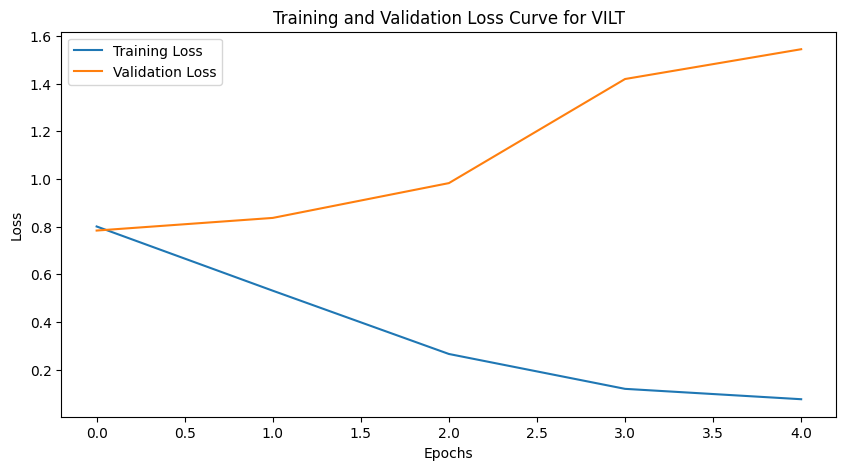

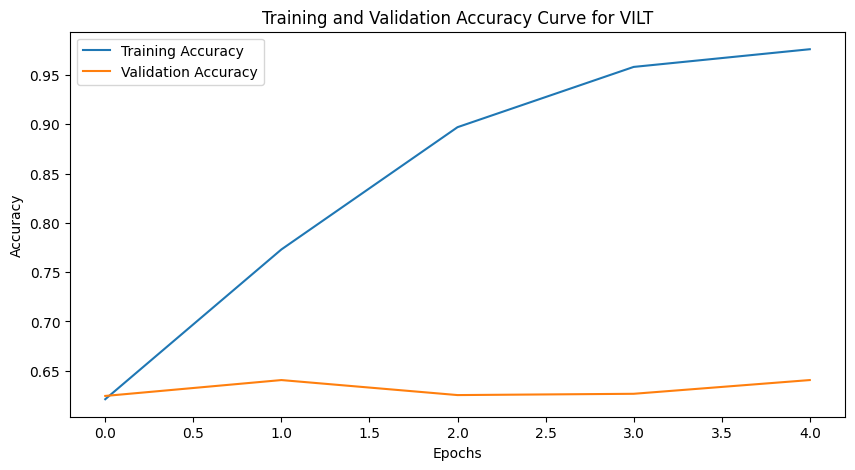

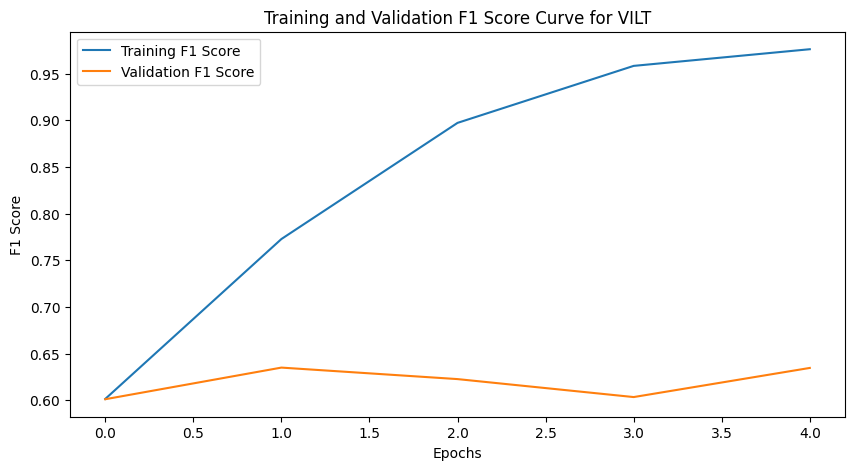

In [12]:
from transformers import ViltProcessor, ViltModel
import torch.nn as nn
import torch
from torch.optim import AdamW
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, images, labels, mode="train"):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.image_size = 224
        self.mode = mode

        if mode == "train":
            self.image_transform = transforms.Compose([
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),  # Recorte aleatorio
                transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
                transforms.RandomRotation(10),  # Rotación aleatoria (±10 grados)
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variaciones de color
                transforms.ToTensor(),
            ])
        else:
            self.image_transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),  # Escalado fijo
                transforms.ToTensor(),
            ])


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Cargar la imagen y convertirla a PIL.Image si es necesario
        image = self.images[idx]
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        image = self.image_transform(image)
        return self.texts[idx], image, self.labels[idx]

# Define collate function
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    
    inputs = processor(images=list(images), text=list(texts), return_tensors="pt", padding=True, truncation=True, max_length=40)

    # Convertir labels a tensores si no lo son
    labels = [torch.tensor(label) if not isinstance(label, torch.Tensor) else label for label in labels]

    # Añadir labels a los inputs
    inputs["labels"] = torch.stack(labels)
    
    return inputs


# Load pre-trained model
model_name = "dandelin/vilt-b32-finetuned-nlvr2"  
#model = ViltForImagesAndTextClassification.from_pretrained(model_name, num_labels=3, num_images=1, ignore_mismatched_sizes=True)
class ViltClassifier(nn.Module):
    def __init__(self, model_name="dandelin/vilt-b32-finetuned-nlvr2", num_labels=3):
        super(ViltClassifier, self).__init__()
        self.model = ViltModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    
    def forward(self, input_ids=None, attention_mask=None, pixel_values=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        pooled_output = outputs.pooler_output 
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits, loss
    

# Load pre-trained model
model = ViltClassifier(model_name=model_name, num_labels=3)
processor = ViltProcessor.from_pretrained(model_name)



# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Create dataset and dataloader
dataset = CustomDataset(X_train, path_image_train, label_encoder.transform(y_train))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataset = CustomDataset(X_dev, path_image_dev, label_encoder.transform(y_dev))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Training loop
model.to(device)
epochs = 5
# Inicializar listas para almacenar pérdidas y métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
time_since = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # Calcular las predicciones
        _, preds = torch.max(logits, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validación después de cada época
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{epochs}', leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)
            val_loss += loss.item()

            # Calcular las predicciones
            _, preds = torch.max(logits, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calcular métricas de validación
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Train Accuracy: {train_accuracy:.4f} - "
          f"Train F1: {train_f1:.4f} - "
          f"Validation Loss: {avg_val_loss:.4f} - "
          f"Validation Accuracy: {val_accuracy:.4f} - "
          f"Validation F1: {val_f1:.4f} - in {time.time()-time_since:.0f}s")
    time_since = time.time()
    
print("Modelo VILT")
print_plots(train_losses, val_losses, title="Training and Validation Loss Curve for VILT", metric="Loss")
print_plots(train_accuracies, val_accuracies, title="Training and Validation Accuracy Curve for VILT", metric="Accuracy")
print_plots(train_f1_scores, val_f1_scores, title="Training and Validation F1 Score Curve for VILT", metric="F1 Score")

### CLIP

Epoch 1 - Train Loss: 0.8148 - Train Accuracy: 0.6070 - Train F1: 0.5942 - Validation Loss: 0.7426 - Validation Accuracy: 0.6432 - Validation F1: 0.6211 - in 278s


Epoch 2 - Train Loss: 0.5336 - Train Accuracy: 0.7763 - Train F1: 0.7759 - Validation Loss: 0.8530 - Validation Accuracy: 0.6305 - Validation F1: 0.6215 - in 278s


Epoch 3 - Train Loss: 0.3221 - Train Accuracy: 0.8761 - Train F1: 0.8762 - Validation Loss: 0.8773 - Validation Accuracy: 0.6549 - Validation F1: 0.6508 - in 276s


Epoch 4 - Train Loss: 0.1813 - Train Accuracy: 0.9349 - Train F1: 0.9349 - Validation Loss: 1.0048 - Validation Accuracy: 0.6471 - Validation F1: 0.6450 - in 275s


Epoch 5 - Train Loss: 0.1313 - Train Accuracy: 0.9549 - Train F1: 0.9549 - Validation Loss: 1.1865 - Validation Accuracy: 0.6601 - Validation F1: 0.6529 - in 276s
Modelo CLIP


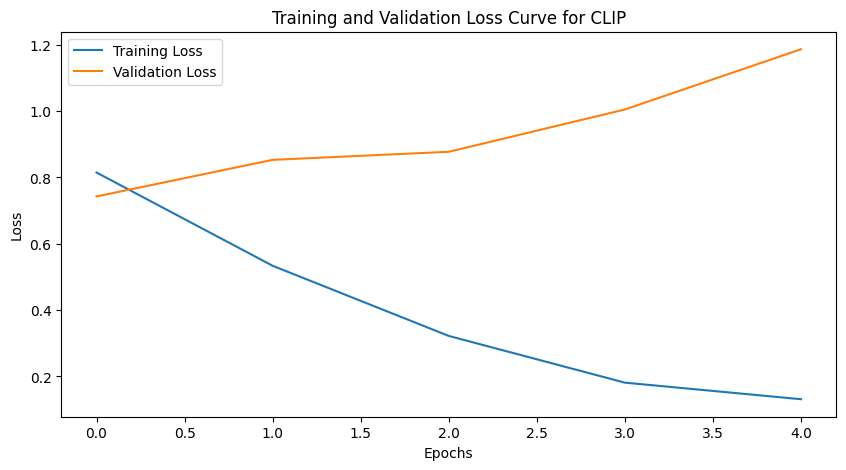

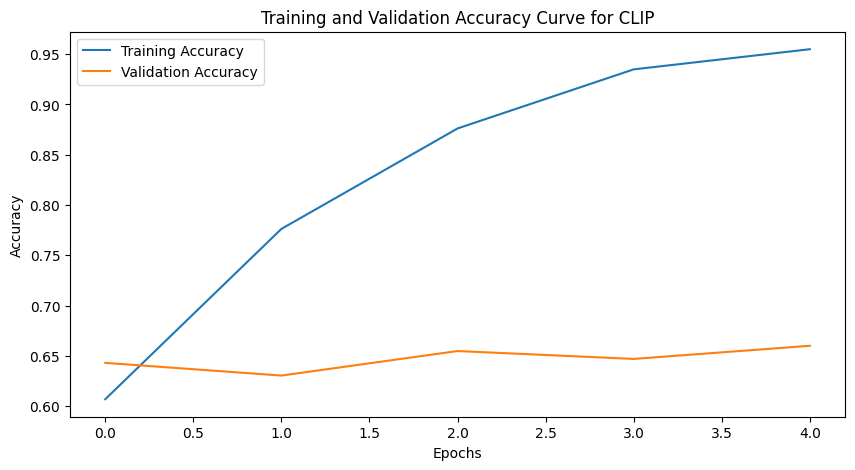

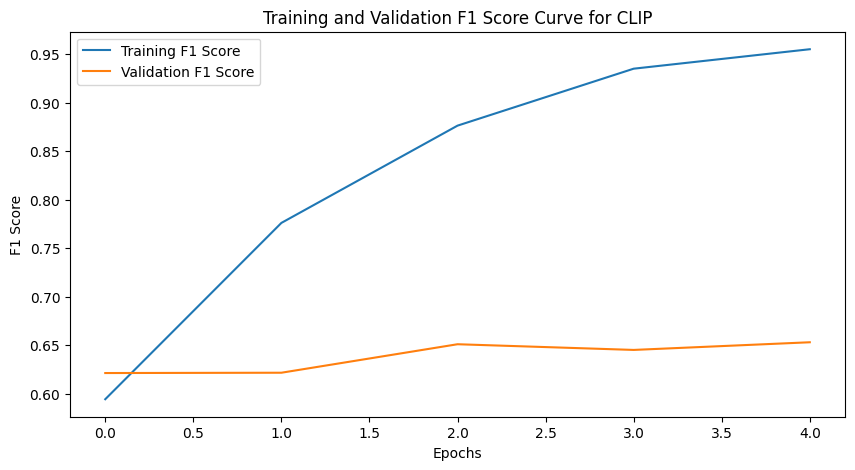

In [13]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
import numpy as np

# Definir el dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, texts, images, labels, mode="train"):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.image_size = 224
        self.mode = mode

        if mode == "train":
            self.image_transform = transforms.Compose([
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),  # Recorte aleatorio
                transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
                transforms.RandomRotation(10),  # Rotación aleatoria (±10 grados)
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variaciones de color
                transforms.ToTensor(),
            ])
        else:
            self.image_transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),  # Escalado fijo
                transforms.ToTensor(),
            ])


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Cargar la imagen y convertirla a PIL.Image si es necesario
        image = self.images[idx]
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        image = self.image_transform(image)
        return self.texts[idx], image, self.labels[idx]

# Definir la función de collate
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    
    # Preprocesar las imágenes y los textos
    inputs = processor(text=list(texts), images=list(images), return_tensors="pt", padding=True, truncation=True, max_length=60)
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Cargar el modelo y el procesador preentrenados
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
class CLIPClassifier(nn.Module):
    def __init__(self, model_name, num_classes=3):
        super(CLIPClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        # Obtener el tamaño de las características generadas por el modelo CLIP
        text_feature_size = self.clip.get_text_features(
            input_ids=torch.tensor([[1, 2, 3, 4, 5]])
        ).size(-1)
        image_feature_size = self.clip.get_image_features(
            pixel_values=torch.randn(1, 3, 224, 224)
        ).size(-1)
        
        # Capa completamente conectada para clasificación
        self.fc = nn.Linear(text_feature_size + image_feature_size, num_classes)  

    def forward(self, input_ids=None, attention_mask=None, pixel_values=None):
        # Obtener características de texto e imagen
        text_features = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip.get_image_features(pixel_values=pixel_values)
        
        # Concatenar características de texto e imagen
        combined_features = torch.cat([text_features, image_features], dim=-1)
        
        # Pasar las características concatenadas por la capa de clasificación
        output = self.fc(combined_features)
        return output

    
# Inicializar el modelo
model = CLIPClassifier(model_name)
model.to(device)

# Definir el optimizador
optimizer = AdamW(model.parameters(), lr=5e-5)

# Crear datasets y dataloaders
train_dataset = CustomDataset(X_train, path_image_train, label_encoder.transform(y_train), mode="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(X_dev, path_image_dev, label_encoder.transform(y_dev), mode="val")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Ciclo de entrenamiento
epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
since = time.time()
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    all_train_labels, all_train_preds = [], []
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        
        # Modificación aquí: `outputs` es ahora directamente el tensor con las logits
        logits = model(**inputs)
        loss = torch.nn.functional.cross_entropy(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)  # Predecir las etiquetas
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)
    
    # Validación
    model.eval()
    val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{epochs}', leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            
            logits = model(**inputs)  # Cambiado aquí también
            loss = torch.nn.functional.cross_entropy(logits, labels)
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)  # Predecir las etiquetas
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Train Accuracy: {train_accuracy:.4f} - "
          f"Train F1: {train_f1:.4f} - "
          f"Validation Loss: {avg_val_loss:.4f} - "
          f"Validation Accuracy: {val_accuracy:.4f} - "
          f"Validation F1: {val_f1:.4f} - in {time.time()-since:.0f}s")
    since = time.time()



print("Modelo CLIP")
print_plots(train_losses, val_losses, title="Training and Validation Loss Curve for CLIP")
print_plots(train_accuracies, val_accuracies, title="Training and Validation Accuracy Curve for CLIP", metric="Accuracy")
print_plots(train_f1_scores, val_f1_scores, title="Training and Validation F1 Score Curve for CLIP", metric="F1 Score")


### Preguntas

* How are the performances using multimodaly pre-trained model, compared with other ones?  
* What is the interest of Instructed Models? What could you see with the results? 

#### Respuesta

* Lo esperado al utilizar modelos multimodales preentrenados es que se logren mejores resultados en comparación con aquellos modelos que combinan modelos separados para texto e imágenes. Sin embargo, en este caso, los resultados no fueron tan destacados como se anticipaba. Los modelos multimodales preentrenados quedaron en un punto intermedio, entre los modelos obtenidos a partir de fine-tuning de RoBERTa para texto y EfficientNet para imágenes, y los modelos sin overfiting. Esto se puede atribuir a que los modelos multimodales tienden a sobreajustarse (overfitting) demasiado rápido en el dataset y la tarea solicitada, lo que limita su capacidad de generalización. Es posible que, aunque el modelo multimodal aproveche el aprendizaje transferido de múltiples modalidades, las características del conjunto de datos y la tarea no sean lo suficientemente complejas o representativas como para justificar el uso de un modelo multimodal preentrenado.

* Los Modelos Instruidos son aquellos entrenados específicamente para seguir instrucciones o realizar tareas orientadas a la resolución de problemas dados en un formato explícito, como en los modelos de tipo InstructGPT. El principal interés de estos modelos radica en su capacidad para adaptarse mejor a las tareas específicas, ya que han sido diseñados para comprender y ejecutar comandos con mayor precisión. A diferencia de modelos entrenados de forma generalista, los modelos instruidos se benefician de una afinación más dirigida, lo que les permite abordar tareas complejas con mejores resultados. Sin embargo, los resultados observados muestran que, aunque estos modelos son útiles, aún pueden enfrentarse a limitaciones si no están alineados adecuadamente con la naturaleza específica de la tarea. La habilidad para seguir instrucciones y ajustarse al contexto de cada tarea varía, y esto puede afectar la efectividad de los modelos en aplicaciones prácticas, dependiendo de la complejidad de las instrucciones dadas y del dominio de la tarea.

### Anexo: modelos multimodales preentrenados que por temas de recursos (GPU, RAM) no pude entrenar

In [19]:
# Estos modelos no los pude correr porque se me acabó la memoria de la gpu (rtx 4060), pero deberían funcionar en una gpu con más memoria
""" from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch.nn as nn
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, images, labels):
        self.texts = texts
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        return self.texts[idx], image, self.labels[idx]

# Define collate function
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    
    # Convert texts to list of strings
    texts = list(texts)
    
    inputs = processor(images=list(images), text=texts, return_tensors="pt", padding=True, truncation=True)

    # Convertir labels a tensores si no lo son
    labels = [torch.tensor(label) if not isinstance(label, torch.Tensor) else label for label in labels]

    # Añadir labels a los inputs
    inputs["labels"] = torch.stack(labels)
    
    return inputs

# Load pre-trained model
model_name = "Salesforce/blip2-opt-2.7b"
model = Blip2ForConditionalGeneration.from_pretrained(model_name)
model.classifier = nn.Linear(model.config.get_text_config().hidden_size, 3)

# Initialize processor
processor = Blip2Processor.from_pretrained(model_name)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Create dataset and dataloader
dataset = CustomDataset(X_train, path_image_train, label_encoder.transform(y_train))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Training loop
device = "cpu" #use el cpu porque se queda sin memoria la gpu, pero en cpu se tarda mucho (no lo pude correr)
model.to(device)
epochs = 5

for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Asegurarse de que las etiquetas tengan la forma correcta
        labels = labels.unsqueeze(1)  # Añadir dimensión para las etiquetas si es necesario

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} - Loss: {loss.item()}")
 """

""" from transformers import LxmertTokenizer, LxmertForQuestionAnswering
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.nn.utils.rnn import pad_sequence

# Definir el dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, texts, images, labels):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])
        self.feature_extractor = fasterrcnn_resnet50_fpn(pretrained=True)
        self.feature_extractor.eval()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        image = self.transform(image)
        
        # Extraer características visuales
        with torch.no_grad():
            features = self.feature_extractor([image])[0]
        
        # Obtén las cajas y las puntuaciones como placeholder
        visual_feats = features['boxes'][:36]  # Toma las primeras 36 detecciones
        visual_pos = features['scores'][:36].unsqueeze(-1)  # Usa puntuaciones como placeholder
        return self.texts[idx], visual_feats, visual_pos, self.labels[idx]

# Función para procesar los lotes (collate_fn)
def collate_fn(batch):
    texts, visual_feats, visual_pos, labels = zip(*batch)

    # Tokenizar textos
    inputs = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)

    # Procesar las características visuales y posiciones
    visual_feats = pad_sequence(visual_feats, batch_first=True)
    visual_pos = pad_sequence(visual_pos, batch_first=True)

    # Convertir etiquetas a tensores
    labels = torch.tensor(labels)

    inputs["visual_feats"] = visual_feats
    inputs["visual_pos"] = visual_pos
    inputs["labels"] = labels

    return inputs

# Modelo personalizado basado en LXMERT
class CustomLXMERT(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomLXMERT, self).__init__()
        self.lxmert = LxmertForQuestionAnswering.from_pretrained(model_name)
        self.classifier = nn.Linear(self.lxmert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, visual_feats, visual_pos, labels=None):
        outputs = self.lxmert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_feats=visual_feats,
            visual_pos=visual_pos
        )
        logits = self.classifier(outputs[0])  # Usa el último hidden state
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return loss, logits

# Inicializar tokenizer y modelo
model_name = "unc-nlp/lxmert-base-uncased"
tokenizer = LxmertTokenizer.from_pretrained(model_name)
num_labels = 3  # Ajusta al número de clases en tu tarea
model = CustomLXMERT(model_name, num_labels)

# Configurar el optimizador
optimizer = AdamW(model.parameters(), lr=5e-5)
dataset = CustomDataset(X_train, path_image_train, label_encoder.transform(y_train))
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Bucle de entrenamiento
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        visual_feats = batch["visual_feats"].to(device)
        visual_pos = batch["visual_pos"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        loss, logits = model(input_ids, attention_mask, visual_feats, visual_pos, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}")

# Evaluación (opcional, implementar según tus datos de validación)
print("Entrenamiento finalizado.")
 """

' from transformers import LxmertTokenizer, LxmertForQuestionAnswering\nimport torch\nimport torch.nn as nn\nfrom torch.optim import AdamW\nfrom torch.utils.data import DataLoader, Dataset\nfrom PIL import Image\nimport torchvision.transforms as T\nfrom torchvision.models.detection import fasterrcnn_resnet50_fpn\nfrom torch.nn.utils.rnn import pad_sequence\n\n# Definir el dataset personalizado\nclass CustomDataset(Dataset):\n    def __init__(self, texts, images, labels):\n        self.texts = texts\n        self.images = images\n        self.labels = labels\n        self.transform = T.Compose([\n            T.Resize((224, 224)),\n            T.ToTensor()\n        ])\n        self.feature_extractor = fasterrcnn_resnet50_fpn(pretrained=True)\n        self.feature_extractor.eval()\n\n    def __len__(self):\n        return len(self.texts)\n\n    def __getitem__(self, idx):\n        image = self.images[idx]\n        if isinstance(image, str):\n            image = Image.open(image).convert("